In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anime
from matplotlib.animation import FuncAnimation

# № 23, нелинейное уравнение теплопроводности

## 1)

$\dfrac{\partial u}{\partial t}= \dfrac{\partial}{\partial x}\left(a u^{\alpha}\dfrac{\partial u}{\partial x}\right), \ \alpha > 0$

$u(\infty, t) = 0, \ u(0, t) = ct^{\alpha^{-1}}, \ u(x, 0) = 0$

Точное решение (по пособию, на самом деле видно что оно не подходит): $u(x, t) = \left(\dfrac{\alpha v}{a}(x-vt) \right)^{\alpha^{-1}}, \ v = \dfrac{a c^{\alpha}}{\alpha}$

Используем разностную схему:

$\displaystyle \frac{u_{m}^{n+1}-u_{m}^{n}}{\tau}=\frac{1}{h}\left(k_{m+\frac{1}{2}} \frac{u_{m+1}^{n+1}-u_{m}^{n+1}}{h}-k_{m-\frac{1}{2}} \frac{u_{m}^{n+1}-u_{m-1}^{n+1}}{h}\right)$

$\alpha = 1,\ 1.5, \ 2; \ a = 0.1, \ 1, \ 10$

Вначале выберем $k_{m+\frac{1}{2}}=\dfrac{a}{2}\left[\left(u_{m}^{n}\right)^{\alpha}+\left(u_{m+1}^{n}\right)^{\alpha}\right]$

In [13]:
def solve(tau, h, end_t, end_x, a, c, alpha, k_type = 1):
    
    x = np.linspace(0, end_x, int(end_x/h), dtype='double')
    t = np.linspace(0, end_t, int(end_t/tau), dtype='double')

    N = len(t)
    M = len(x)

    y = np.empty([N, M], dtype='double')
    
    # ставим граничные условия
    for i in range(M):
        y[0][i] = 0

    for i in range(N):
        y[i][0] = c * t[i] ** (1/alpha)
        y[i][M-1] = 0
        
    k = np.empty(M-1, dtype='double')
    
    y_new = np.empty(M-2, dtype='double')
    f = np.empty_like(y_new)
    A = np.zeros([M-2, M-2], dtype='double')
        
    for n in range(0, N-1):
        
        for m in range(M-1):
            if y[n][m] == 0 and y[n][m+1] == 0:
                k[m] = 0
            elif k_type == 1:
                k[m] = a/2 * ((y[n][m]) ** alpha + (y[n][m + 1]) ** alpha)
            elif k_type == 2:
                k[m] = a * ((y[n][m] + y[n][m + 1]) / 2) ** alpha
            elif k_type == 3:
                k[m] = a * (2 * y[n][m] * y[n][m + 1] / (y[n][m] + y[n][m + 1])) ** alpha
            elif k_type == 4:
                k[m] = a * 2 * (y[n][m] * y[n][m + 1]) ** alpha / ((y[n][m]) ** alpha + (y[n][m + 1]) ** alpha)
        
        # Чтобы найти n+1 слой решаем систему A.dot(y_new) = f
        # Инициализируем A и f
        f[0] = y[n][1] + tau / h**2 * k[0] * y[n + 1][0]
        f[M-3] = y[n][M-2] + tau / h**2 * k[M - 2] * y[n + 1][M - 1]
        
        A[0][0] = 1 + tau / h**2 * (k[1]+k[0])
        A[0][1] = -tau / h**2 * k[1]
        
        A[M-3][M-3] = 1 + tau / h**2 * (k[M - 2] + k[M - 3])
        A[M-3][M-4] = -tau / h**2 * k[M - 3]
        for m in range(1, M-3):
            f[m] = y[n][m + 1]
            
            A[m][m] = 1 + tau / h**2 * (k[m + 1] + k[m])
            A[m][m-1] = -tau / h**2 * k[m]
            A[m][m+1] = -tau / h**2 * k[m + 1]
            
        y_new = np.linalg.solve(A, f)
        
        for m in range(1, M - 1):
            y[n+1][m] = y_new[m - 1]

    return y, x, t, N, M

In [3]:
def real_sol(x, t, a, c, alpha):
    M = len(x)
    N = len(t)
    
    u = np.empty([N, M], dtype='double')
    
    v = a * c ** alpha / alpha
    
    for i in range(N):
        for j in range(M):
            u[i][j] = (alpha * v / a * (x[j] - v * t[i])) ** (1/alpha)
            
    return u

In [4]:
def plot_n(n, y1, y2, y3, u, x, t, a, alpha):
    plt.clf()
    plt.title(f"График функции при t = {t[n]:.3f}")
    plt.xlabel("x")
    plt.ylabel("u")
    
    plt.plot(x, y1[n], label='решение схемой, a=' + str(a[0]) + ', alpha=' + str(alpha[0]))
    plt.plot(x, y2[n], label='решение схемой, a=' + str(a[1]) + ', alpha=' + str(alpha[1]))
    plt.plot(x, y3[n], label='решение схемой, a=' + str(a[2]) + ', alpha=' + str(alpha[2]))
    #plt.plot(x, u[n], label='реальное решение')
    plt.legend()
    
    return plt

In [5]:
alpha = np.array([1, 1.5, 2])
a = np.array([0.1, 1, 10])
tau = 0.005
h = 0.05
x_end = 5
t_end = 5
c = 1

y1, x, t, N, M = solve(tau, h, t_end, x_end, a[0], c, alpha[0])
y2, _, _, _, _ = solve(tau, h, t_end, x_end, a[1], c, alpha[1])
y3, _, _, _, _ = solve(tau, h, t_end, x_end, a[2], c, alpha[2])

In [6]:
u = real_sol(x, t, 0.1, 1, 1)

<IPython.core.display.Javascript object>


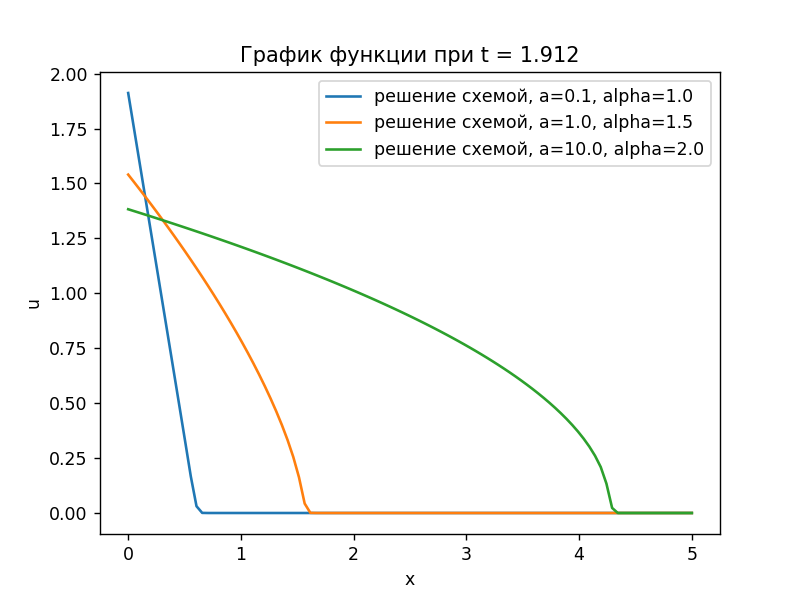

In [7]:
%matplotlib notebook

num_frames = 500
def animate(n):
    n = int(n / num_frames * N)
    plot_n(n, y1, y2, y3, u, x, t, a, alpha)
    
anim = anime.FuncAnimation(plt.figure(), animate, interval = 2, frames = num_frames, repeat = False)
plt.show()

## 2)

Сравним как ведет себя решение при выборе разных способов вычисления k:

a) $k_{m+\frac{1}{2}}=\dfrac{a}{2}\left[\left(u_{m}^{n}\right)^{\alpha}+\left(u_{m+1}^{n}\right)^{\alpha}\right]$

б) $k_{m+\frac{1}{2}}=a\left(\dfrac{u_{m}^{n}+u_{m+1}^{n}}{2}\right)^{\alpha}$

в) $k_{m+\frac{1}{2}}=a\left(\dfrac{2 u_{m}^{n} u_{m+1}^{n}}{u_{m}^{n}+u_{m+1}^{n}}\right)^{\alpha}$

г) $k_{m+\frac{1}{2}}=a \dfrac{2\left(u_{m}^{n}\right)^{\alpha}\left(u_{m+1}^{n}\right)^{\alpha}}{\left(u_{m}^{n}\right)^{\alpha}+\left(u_{m+1}^{n}\right)^{\alpha}}$

In [20]:
tau = 0.005
h = 0.05
x_end = 5
t_end = 5
c = 1
a = 10
alpha = 2
y1, x, t, N, M = solve(tau, h, t_end, x_end, a, c, alpha, 1)
y2, _, _, _, _ = solve(tau, h, t_end, x_end, a, c, alpha, 2)
y3, _, _, _, _ = solve(tau, h, t_end, x_end, a, c, alpha, 3)
y4, _, _, _, _ = solve(tau, h, t_end, x_end, a, c, alpha, 4)

In [21]:
def plot_dif_k_n(n):
    plt.clf()
    plt.title(f"График функции при t = {t[n]:.3f}")
    plt.xlabel("x")
    plt.ylabel("u")
    
    plt.plot(x, y1[n], label='решение при а)')
    plt.plot(x, y2[n], label='решение при б)')
    plt.plot(x, y3[n], label='решение при в)')
    plt.plot(x, y4[n], label='решение при г)')
    plt.legend()
    
    return plt

<IPython.core.display.Javascript object>


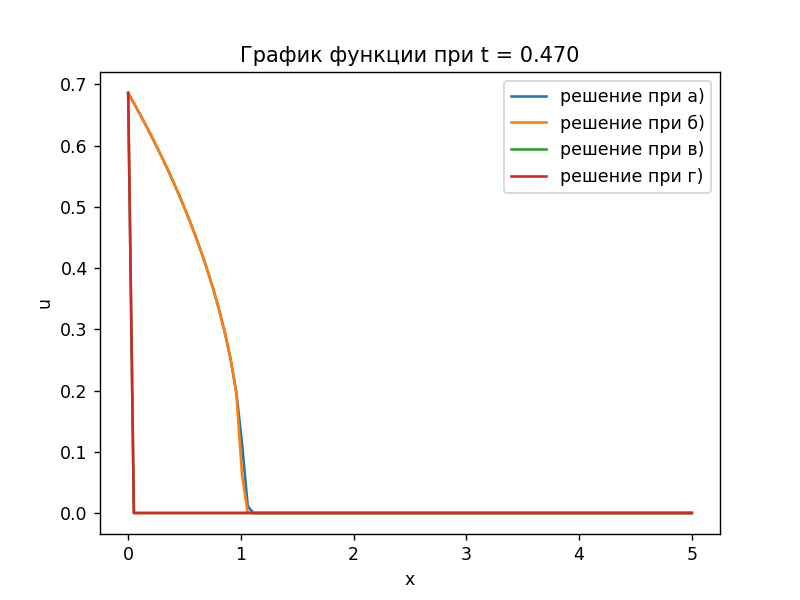

In [22]:
%matplotlib notebook

num_frames = 500
def animate_k(n):
    n = int(n / num_frames * N)
    plot_dif_k_n(n)
    
anim = anime.FuncAnimation(plt.figure(), animate_k, interval = 2, frames = num_frames, repeat = False)
plt.show()

Лучшая аппроксимация k - а) или б). Из-за нулевых начальных условий аппроксимация в) и г) не работает. Не ноль в начале только значение на левой границе $u_{0}^{0}$. Соответсвенно при вычислении значения на 1 слое когда считается $k_{\frac{1}{2}}=a\left(\dfrac{2 u_{0}^{0} u_{1}^{0}}{u_{0}^{0}+u_{1}^{0}}\right)^{\alpha}$ происходит умножение $u_{0}^{0}$ на $u_{1}^{0}$, а $u_{1}^{0} = 0$, а значит $k_{\frac{1}{2}} = 0$ и все последующие $k_{m+\frac{1}{2}}=0$. Соотвественно все значения на 1 слое, кроме значения слева, равны нулю. Далее это будет происходить и при всех других значениях $n$. Значит все решение обращается в ноль, кроме значения слева.

## 4)

Решаем $u_t = u_{xx}$ с теми же граничными и начальным условиями на явной четырехточечной (1), неявной четырехточечной (2) и шеститочечной схеме (3)

In [34]:
def solve_st(tau, h, end_t, end_x, c, alpha, scheme=1, ksi = 0):
    
    x = np.linspace(0, end_x, int(end_x/h), dtype='double')
    t = np.linspace(0, end_t, int(end_t/tau), dtype='double')

    N = len(t)
    M = len(x)

    y = np.empty([N, M], dtype='double')
    
    # ставим граничные условия
    for i in range(M):
        y[0][i] = 0

    for i in range(N):
        y[i][0] = c * t[i] ** (1/alpha)
        y[i][M-1] = 0
        
    k = np.empty(M-1, dtype='double')
    
    y_new = np.empty(M-2, dtype='double')
            
    f = np.empty_like(y_new)
    A = np.zeros([M-2, M-2], dtype='double')
        
    for n in range(0, N-1):
        
        if scheme == 1: 
            for m in range(1, M-1):
                y[n+1][m] = y[n][m] + tau / (h **2) * (y[n][m+1]-2*y[n][m]+y[n][m-1])
                                
        elif scheme == 2:
            #pass
            f[0] = y[n][1] / tau + 1 / h**2 * y[n + 1][0]
            f[M-3] = y[n][M-2]/tau + 1 / h**2 * y[n + 1][M - 1]

            A[0][0] = 1/tau + 2/h**2
            A[0][1] = -1 / h**2

            A[M-3][M-3] = 1/tau + 2 / h**2 
            A[M-3][M-4] = -1 / h**2
            for m in range(1, M-3):
                f[m] = y[n][m+1]/tau

                A[m][m] = 1/tau + 2/ h**2
                A[m][m-1] = -1 / h**2
                A[m][m+1] = -1 / h**2

            y_new = np.linalg.solve(A, f)

            for m in range(1, M - 1):
                y[n+1][m] = y_new[m - 1]
            
        
        elif scheme == 3:
            f[0] = y[n][1] + ksi * tau / h**2 * y[n + 1][0] + (1-ksi) * tau / h**2 * (y[n][0]-2*y[n][1]+y[n][2])
            f[M-3] = y[n][M-2] + ksi * tau / h**2 * y[n + 1][M - 1] + (1-ksi) * tau / h**2 * (y[n][M-1]-2*y[n][M-2]+y[n][M-3])

            A[0][0] = 1 + 2*ksi* tau / h**2
            A[0][1] = -ksi*tau / h**2

            A[M-3][M-3] = 1 + 2*ksi*tau / h**2 
            A[M-3][M-4] = -ksi*tau / h**2
            for m in range(1, M-3):
                f[m] = y[n][m+1] + (1-ksi) * tau / h**2 * (y[n][m]-2*y[n][m+1]+y[n][m+2])

                A[m][m] = 1 + 2  * ksi * tau / h**2
                A[m][m-1] = -ksi * tau / h**2
                A[m][m+1] = -ksi * tau / h**2

            y_new = np.linalg.solve(A, f)

            for m in range(1, M - 1):
                y[n+1][m] = y_new[m - 1]

    return y, x, t, N, M

In [35]:
tau = 0.001
h = 0.05
x_end = 6
t_end = 2
c = 1
alpha = 2
y1, x, t, N, M = solve_st(tau, h, t_end, x_end, c, alpha, 1)
y2, _, _, _, _ = solve_st(tau, h, t_end, x_end, c, alpha, 2)
y3, _, _, _, _ = solve_st(tau, h, t_end, x_end, c, alpha, 3, 1/2)

In [36]:
def plot_dif_scheme(n, y1, y2, y3, x, t):
    plt.clf()
    plt.title(f"График функции при t = {t[n]:.3f}")
    plt.xlabel("x")
    plt.ylabel("u")
    
    plt.plot(x, y1[n], label='решение cхемой 1')
    plt.plot(x, y2[n], label='решение схемой 2')
    plt.plot(x, y3[n], label='решение схемой 3')
    plt.legend()
    
    return plt

<IPython.core.display.Javascript object>


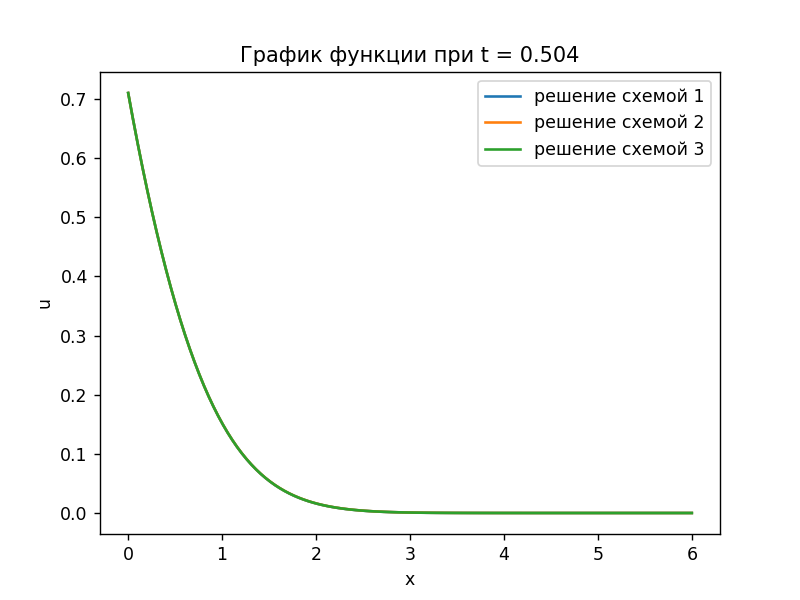

In [37]:
%matplotlib notebook

num_frames = 500
def animate_k(n):
    n = int(n / num_frames * N)
    plot_dif_scheme(n, y1, y2, y3, x, t)
    
anim = anime.FuncAnimation(plt.figure(), animate_k, interval = 2, frames = num_frames, repeat = False)
plt.show()

Решения всеми тремя схемами очень близки